In [1]:
# import required modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cooltools
import bioframe
import cooler

from cooltools import eigdecomp
import HMMC
from pybedtools import BedTool


In [2]:
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'

In [3]:
fasta_file='/pollard/data/vertebrate_genomes/human/hg38/hg38/hg38.fa'

In [4]:
cooler.fileops.list_coolers(cooler_file)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000',
 '/resolutions/2500000',
 '/resolutions/5000000',
 '/resolutions/10000000']

In [5]:
# load cooler, obtain bin table
resolution = 25000
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))
chromsizes = c.chromsizes      
bins = c.bins()[:]

In [6]:
fasta_records = bioframe.load_fasta(fasta_file)
gc_table = bioframe.genomeops.frac_gc(bins, fasta_records)

In [7]:
regions = HMMC.chrom_regions('hg38', chromsizes)
regions

[('chr1', 0, 248956422),
 ('chr2', 0, 242193529),
 ('chr3', 0, 198295559),
 ('chr4', 0, 190214555),
 ('chr5', 0, 181538259),
 ('chr6', 0, 170805979),
 ('chr7', 0, 159345973),
 ('chr8', 0, 145138636),
 ('chr9', 0, 138394717),
 ('chr10', 0, 133797422),
 ('chr11', 0, 135086622),
 ('chr12', 0, 133275309),
 ('chr13', 0, 114364328),
 ('chr14', 0, 107043718),
 ('chr15', 0, 101991189),
 ('chr16', 0, 90338345),
 ('chr17', 0, 83257441),
 ('chr18', 0, 80373285),
 ('chr19', 0, 58617616),
 ('chr20', 0, 64444167),
 ('chr21', 0, 46709983),
 ('chr22', 0, 50818468)]

In [8]:
def get_transmaps(c, chrom, regions):
    contact_maps = list()
    for region in regions:
        if region[0]==chrom:
            continue
        contact_maps.append(c.matrix(balance=True).fetch(region[0],chrom))
        
    return np.concatenate(contact_maps, axis=0)

In [9]:
def get_allcontacts(c, chrom, regions):
    contact_maps = list()
    for region in regions:
        contact_maps.append(c.matrix(balance=True).fetch(region[0],chrom))
        
    return np.concatenate(contact_maps, axis=0)

In [27]:
contact_map = c.matrix(balance=True).fetch('chr22','chr19')

In [212]:
contact_map.sum(axis=0)

array([nan, nan, nan, ..., nan, nan, nan])

In [187]:
contact_map2 = contact_map.copy()
contact_map2[np.isnan(contact_map)] = 0
mask1 = contact_map2.sum(axis=1) != 0
mask2 = contact_map2.sum(axis=0) != 0
contact_map_masked = contact_map2[:,mask2][mask1]
contact_map_masked = contact_map_masked

In [220]:
def correction(M, iterations = 10):
    W = M.copy()
    for i in range(iterations):
        B0 = W.sum(axis=1)
        B1 = W.sum(axis=0)
        B0[B0==0]=1
        B1[B1==0]=1
        B0 = B0/(B0.mean())
        B1 = B1/(B1.mean())
        outer = np.outer(B0, B1)
        W = W/outer
    
    return W

In [221]:
contact_map_masked = correction(contact_map_masked, 300)

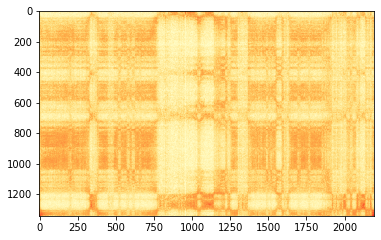

In [275]:
plt.imshow(np.log(contact_map_masked+1e-6), cmap='YlOrRd')

In [276]:
C = np.dot(contact_map_masked.T, contact_map_masked)
C = np.clip(C,np.percentile(C,1), np.percentile(C,99))
C = np.log(C)
C = (C - C.min())
C = C*2/ C.max()
C = C - np.median(C)

(array([ 180834.,  255568.,  406738.,  604784.,  931420., 1232490.,
         863582.,  173154.,   72298.,   97157.]),
 array([-1.0051046, -0.8051046, -0.6051046, -0.4051046, -0.2051046,
        -0.0051046,  0.1948954,  0.3948954,  0.5948954,  0.7948954,
         0.9948954]),
 <BarContainer object of 10 artists>)

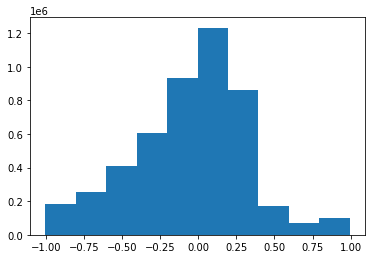

In [277]:
plt.hist(C.reshape(-1))

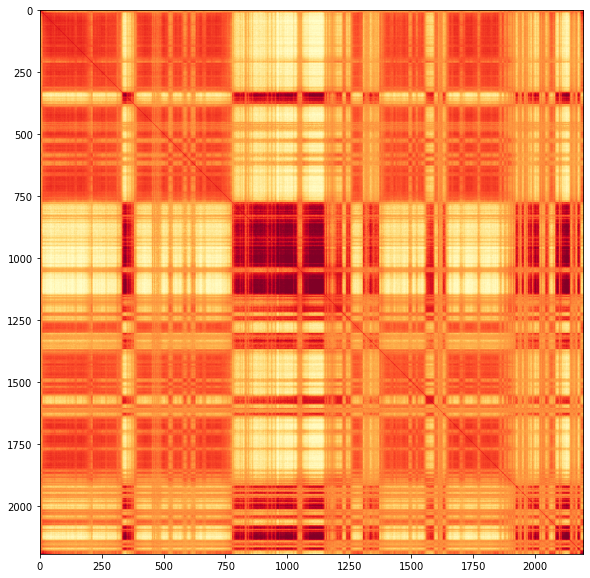

In [278]:
plt.figure(figsize=(10, 10))
plt.imshow(C, cmap='YlOrRd')

In [279]:
U, S, V = np.linalg.svd(C)

In [280]:
np.round(S[:10]/(np.sum(np.abs(S))), 2)

array([0.1 , 0.02, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

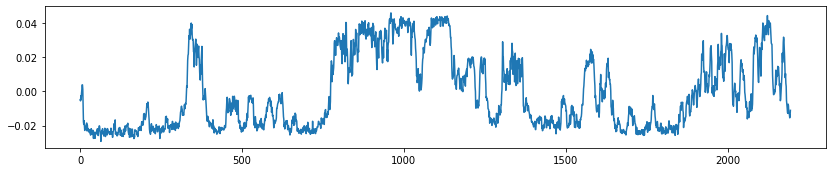

In [281]:
plt.figure(figsize=(14, 2.6))
plt.plot(U[:,0])

In [282]:
mask2 = np.where(U[:,0]>0, True, False)

In [283]:
from hmmlearn import hmm

def _make_transmat(n_states, constrained=False):
    transmat = np.ones((n_states, n_states)) / 10
    np.fill_diagonal(transmat, 0.6)
    transmat /= transmat.sum(axis=1, keepdims=True)
    return transmat

def build_hmm(data, n_components=3, verbose=False):
    model = hmm.GaussianHMM(n_components, params='stmc', init_params='sc', covariance_type="tied", tol=1e-30, n_iter=100)
    model.means_ = np.percentile(data, [20, 50, 80], axis=0)
    
    model.transmat_ = _make_transmat(n_components)
    if verbose:
#         print("means:", model.means_)
        print("transmat:", model.transmat_)
    
    return model



In [284]:
data = -U[:, 0:1]

In [285]:
model = build_hmm(data, verbose=True)
model.fit(data)

transmat: [[0.75  0.125 0.125]
 [0.125 0.75  0.125]
 [0.125 0.125 0.75 ]]


GaussianHMM(algorithm='viterbi', covariance_type='tied', covars_prior=0.01,
            covars_weight=1, init_params='sc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=1e-30,
            transmat_prior=1.0, verbose=False)

In [286]:
np.round(model.transmat_,3)

array([[0.97 , 0.03 , 0.   ],
       [0.027, 0.955, 0.019],
       [0.   , 0.007, 0.993]])

In [287]:
prediction = model.predict(data)

In [288]:
x = np.arange(0, len(data))

In [289]:
# plt.scatter(data[:,0], data[:,1], c=prediction)

In [290]:
# X, X_p = model.sample(10000, random_state=1997)
# plt.scatter(X[:,0], X[:,1], c=X_p)

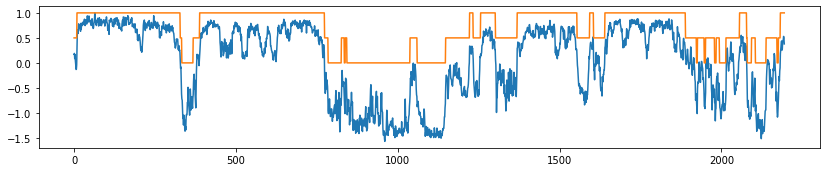

In [291]:
%matplotlib inline
plt.figure(figsize=(14, 2.6))
plt.plot(data[:,0]/(data[:,0].max()))
plt.plot(prediction/2)